# Learning data correlation and column engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# df = pd.read_csv("../data/X_train.csv")
df = pd.read_csv("../data/orig_test.csv")


In [2]:
def plot_corr(corr, threshold_up=0.8, threshold_down=0.01, threshold_sign=0.6, hue=None):
    if hue is not None and isinstance(hue, str):
        hue = [hue]
    mask = np.triu(np.ones_like(corr, dtype=bool))
    heatmap = sns.heatmap(corr, mask=mask, linewidths=1, cmap="bwr")
    
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i > j:
                corr_val = corr.iloc[i, j]
                if abs(corr_val) >= threshold_up:
                    heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green'))
                    plt.text(j + 0.5, i + 0.6, f"{corr_val:1.2f}", ha='center', va='center', fontsize=7, color='white')
                elif abs(corr_val) >= threshold_sign:
                    plt.text(j + 0.5, i + 0.6, f"{corr_val:1.2f}", ha='center', va='center', fontsize=7, color='black')
                    
                if abs(corr_val) <= threshold_down:
                    heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='gray', alpha=0.7))
                    plt.text(j + 0.5, i + 0.6, f"{corr_val:1.2f}", ha='center', va='center', fontsize=7, color='white')
                if hue is not None and corr.columns[i] in hue or corr.columns[j] in hue:
                    heatmap.add_patch(plt.Rectangle((j, i), 1, 1, edgecolor='black', fill=False, linewidth=2.5))

    return heatmap

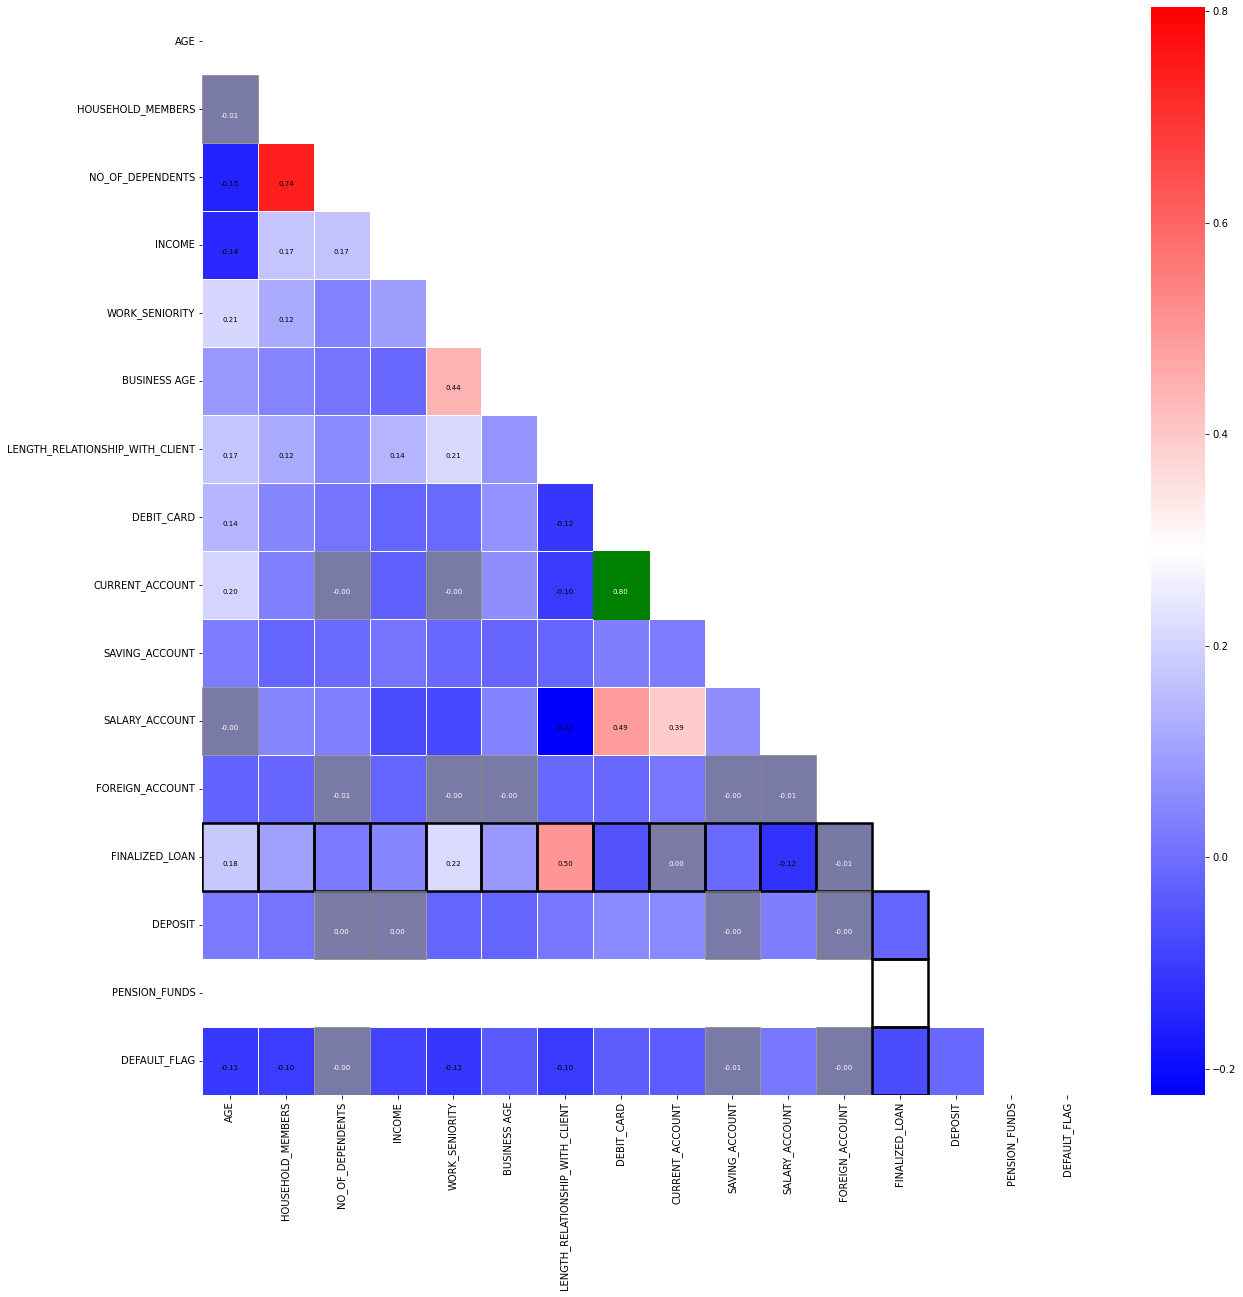

In [3]:
plt.figure(figsize=(20, 20))
corr = df.corr()
plot_corr(corr, hue=["FINALIZED_LOAN"], threshold_down=0.01, threshold_up=0.8, threshold_sign=0.1)
plt.savefig("correlation.png", dpi=100, bbox_inches='tight')
plt.show()

Columns that share a very high level of correlation:
* CURRENT_ACCOUNT & DEBIT_CARD: **0.81**
* HOUSEHOLD_MEMBERS & MARITAL_STATUS_maried: **0.81**
* RESIDENTAL_PLACE_Living with family & RESIDENTAL_PLACE_Owner without mortgage: **-0.85**

Some more columns with high level of correlation:
* FINALIZED_LOAN & LENGTH_RELATIONSHIP_WITH_CLIENT
* MARITAL_STATUS_married & MARITAL_STATUS_single
* RESIDENTAL_PLACE_Owner without mortgage & AGE
* HOUSEHOLD_MEMBERS & NO_OF_DEPENDENTS
* SALARY_ACCOUT & CURRENT_ACCOUT

In [4]:
pd.DataFrame([
    [
        f"{len(df.iloc[np.where((df['CURRENT_ACCOUNT'] == i) & (df['DEBIT_CARD'] == j))]) * 100 / len(df):.3f}% ({len(df.iloc[np.where((df['CURRENT_ACCOUNT'] == i) & (df['DEBIT_CARD'] == j))])})"
        for i in range(2)
    ]
    for j in range(2)
], columns=["CURRENT_ACCOUNT_0", "CURRENT_ACCOUNT_1"], index=[["DEBIT_CARD_0", "DEBIT_CARD_1"]])

,CURRENT_ACCOUNT_0,CURRENT_ACCOUNT_1
DEBIT_CARD_0,50.340% (1629),10.754% (348)
DEBIT_CARD_1,0.000% (0),38.906% (1259)


We can see that if a person does not have an account that implies that they most surely dont have a debit card. In this situation we may want to cut down the number of possible outcomes in the matrix above. We think the best option would be to merge these two column into one like this:

Column name: HAS_CURRENT_ACCOUNT
Values:
* with debit card
* without debit card
* no

Then using one hot we will split it

In [5]:
# Create a copy of the 'CURRENT_ACCOUNT' column with a new name
df['HAS_CURRENT_ACCOUNT'] = df['CURRENT_ACCOUNT']

# Replace boolean values with strings in the new column
df.loc[(df['DEBIT_CARD'] == True) & (df['CURRENT_ACCOUNT'] == True), 'HAS_CURRENT_ACCOUNT'] = 'with debit card'
df.loc[(df['DEBIT_CARD'] == False) & (df['CURRENT_ACCOUNT'] == False), 'HAS_CURRENT_ACCOUNT'] = 'no'

# Replace False values with 'without debit card' only if 'DEBIT_CARD' is False in the new column
df.loc[(df['DEBIT_CARD'] == False) & (df['CURRENT_ACCOUNT'] == True), 'HAS_CURRENT_ACCOUNT'] = 'without debit card'



In [6]:
df = pd.get_dummies(df, columns=['HAS_CURRENT_ACCOUNT'])
df.drop(['CURRENT_ACCOUNT', 'DEBIT_CARD'], axis=1, inplace=True)

Taking into consideration out business case we want to predict if a loan will be finalized. Here are some of indicators that may be lead to a better understanding of the data:

* LENGTH_RELATIONSHIP_WITH_CLIENT to WORK_SENIORITY ratio
* INCOME TO WORK_SENIORITY ratio
* BUSINESS_AGE to AGE ratio
* LENGTH_RELATIONSHIP_WITH_CLIENT to BUSINESS_AGE ratio
* INCOME to LENGTH_RELATION_WITH_CLIENT ratio

In [7]:
df = pd.read_csv("../data/X_train.csv")
df['LENGTH_RELATIONSHIP_WITH_CLIENT_TO_WORK_SENIORITY'] = df['LENGTH_RELATIONSHIP_WITH_CLIENT'] / df['WORK_SENIORITY']
df['INCOME_TO_WORK_SENIORITY_RATIO'] = df['INCOME'] / df['WORK_SENIORITY']
df['BUSINESS_AGE_TO_AGE_RATIO'] = df['BUSINESS_AGE']/ df['WORK_SENIORITY']
df['LENGTH_RELATIONSHIP_WITH_CLIENT_TO_BUSINESS_AGE'] = df['LENGTH_RELATIONSHIP_WITH_CLIENT'] / df['BUSINESS_AGE']
df['INCOME_TO_LENGTH_RELATIONSHIP_WITH_CLIENT'] =  df['INCOME']/ df['LENGTH_RELATIONSHIP_WITH_CLIENT']


Additionally we will implement a credit scoring system. There is a weighted system where we can see what features we value the most from our business perspective. Income and length relationship with client are the most important. There are some features that we believe are negative like being single from MARITAL_STATUS.


In [8]:
# Defining feature weights
feature_weights = {
    'INCOME': 0.4,
    'WORK_SENIORITY': 0.3,
    'BUSINESS_AGE': 0.1,
    'LENGTH_RELATIONSHIP_WITH_CLIENT': 0.4,
    'AGE': 0.4,
    'EDUCATION': 0.4,
    'HAS_DEPENDENTS': 0.2,
    'MARITAL_STATUS_married': 0.3,
    'MARITAL_STATUS_single': -0.2,
    'RESIDENTIAL_PLACE_Owner without mortgage': 0.1
}

# Calculating total score for each individual
df['Total_Score'] = (
    df['INCOME'] * feature_weights['INCOME'] +
    df['WORK_SENIORITY'] * feature_weights['WORK_SENIORITY'] +
    df['BUSINESS_AGE'] * feature_weights['BUSINESS_AGE'] +
    df['LENGTH_RELATIONSHIP_WITH_CLIENT'] * feature_weights['LENGTH_RELATIONSHIP_WITH_CLIENT'] +
    df['AGE'] * feature_weights['AGE'] +
    df['EDUCATION'] * feature_weights['EDUCATION'] + 
    df['MARITAL_STATUS_married'] * feature_weights['MARITAL_STATUS_married'] +
    df['MARITAL_STATUS_single'] * feature_weights['MARITAL_STATUS_single'] +
    df['RESIDENTIAL_PLACE_Owner without mortgage'] * feature_weights['RESIDENTIAL_PLACE_Owner without mortgage'] 


)

# Normalizing total scores to a range between 0-1 
min_score = df['Total_Score'].min()
max_score = df['Total_Score'].max()
df['CREDIT_SCORE'] = (df['Total_Score'] - min_score) / (max_score - min_score)
df.drop(columns=['Total_Score'], inplace=True)


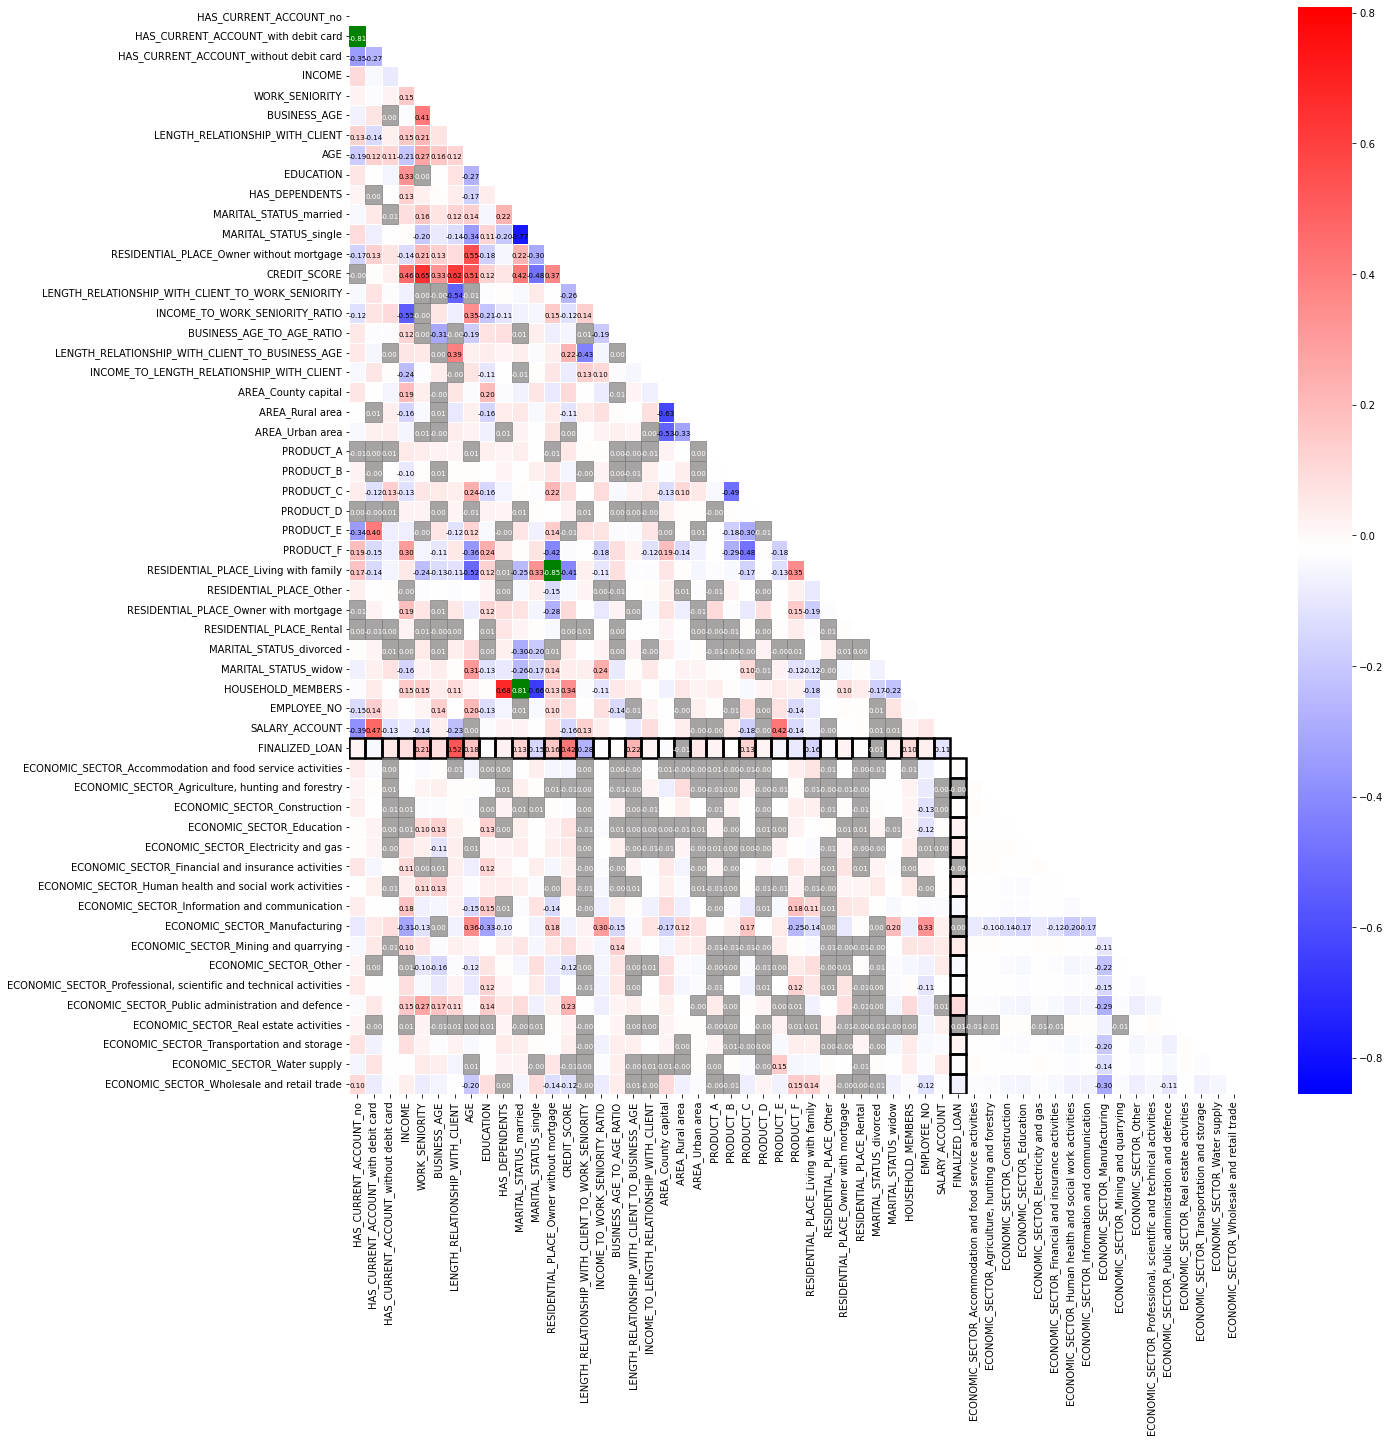

In [9]:
plt.figure(figsize=(20, 20))
corr = df.corr()
plot_corr(corr, hue=["FINALIZED_LOAN"], threshold_down=0.01, threshold_up=0.8, threshold_sign=0.1)
plt.savefig("correlation.png", dpi=100, bbox_inches='tight')
plt.show()

In [10]:
X = df.copy()
y = X.pop("FINALIZED_LOAN")
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

In [11]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  

LENGTH_RELATIONSHIP_WITH_CLIENT_TO_WORK_SENIORITY                    0.180658
LENGTH_RELATIONSHIP_WITH_CLIENT_TO_BUSINESS_AGE                      0.172291
LENGTH_RELATIONSHIP_WITH_CLIENT                                      0.170286
CREDIT_SCORE                                                         0.127952
INCOME_TO_LENGTH_RELATIONSHIP_WITH_CLIENT                            0.065286
BUSINESS_AGE_TO_AGE_RATIO                                            0.031638
AGE                                                                  0.030263
WORK_SENIORITY                                                       0.027168
INCOME_TO_WORK_SENIORITY_RATIO                                       0.021100
RESIDENTIAL_PLACE_Owner without mortgage                             0.017088
INCOME                                                               0.015776
MARITAL_STATUS_single                                                0.014027
RESIDENTIAL_PLACE_Living with family                            

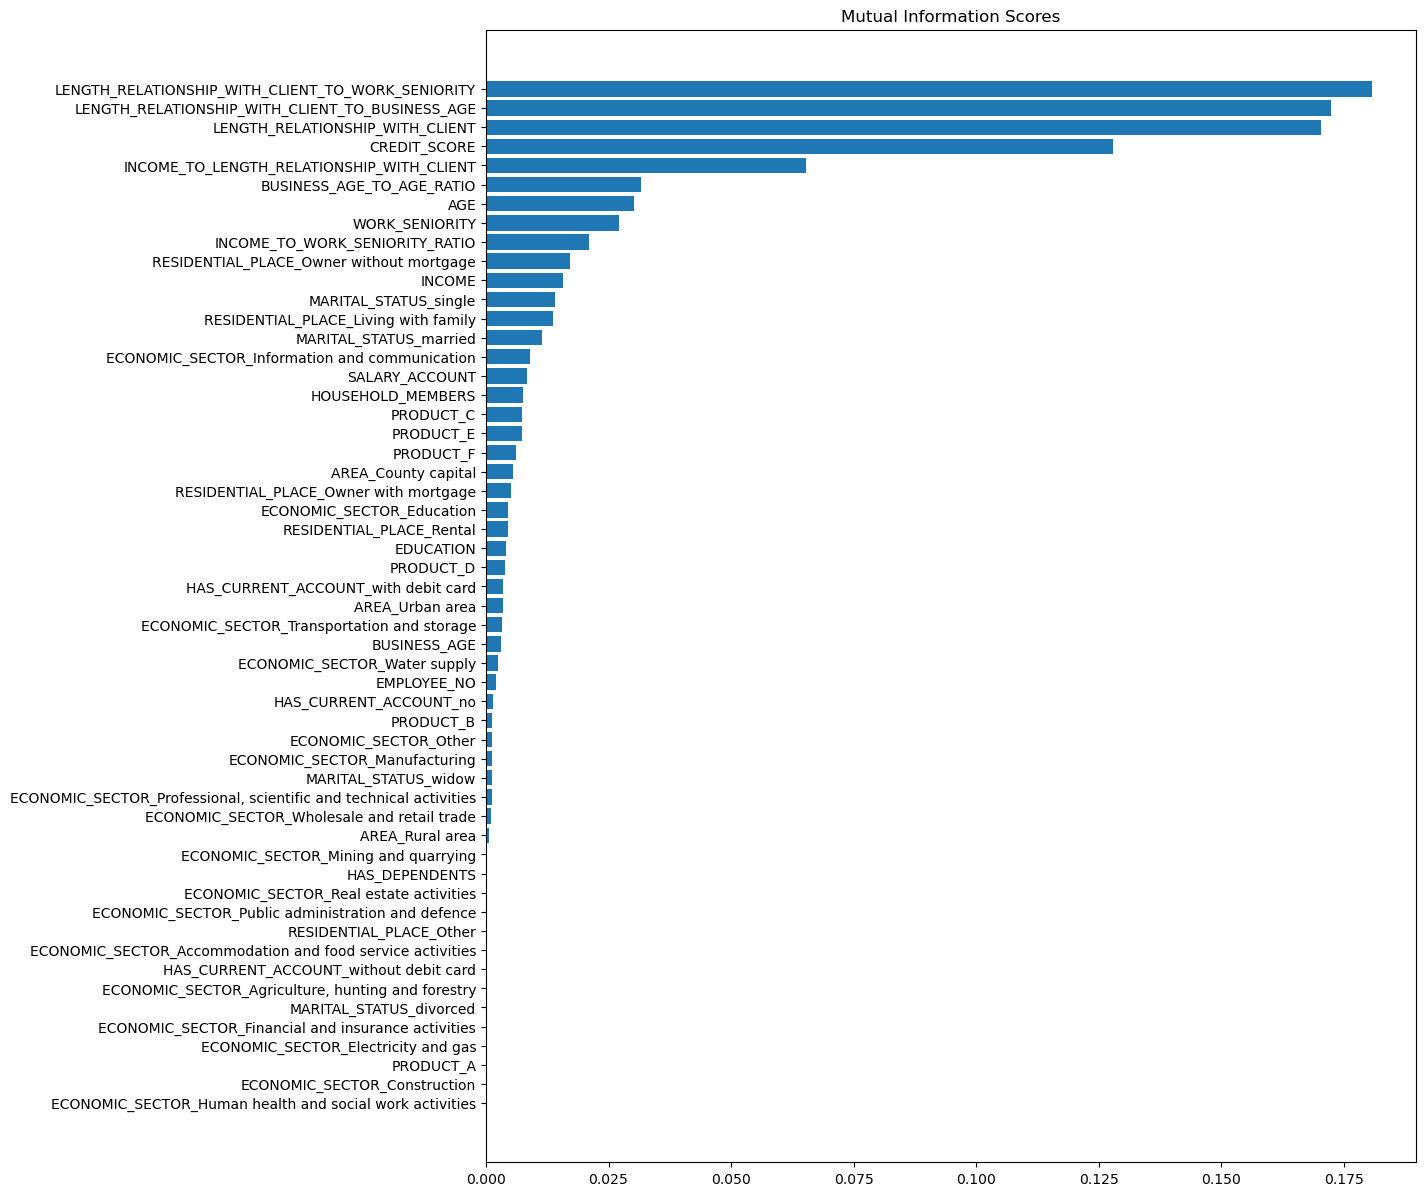

In [12]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(12, 15))
plot_mi_scores(mi_scores)

**Highly Informative Features:**
* LENGTH_RELATIONSHIP_WITH_CLIENT: 0.17
* AGE: 0.03422917231992417

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder



class CreateHasCurrentAccountColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create a copy of the 'CURRENT_ACCOUNT' column with a new name
        X['HAS_CURRENT_ACCOUNT'] = X['CURRENT_ACCOUNT'].astype('object')
        
        # Replace boolean values with strings in the new column
        X.loc[(X['DEBIT_CARD'] == True) & (X['CURRENT_ACCOUNT'] == True), 'HAS_CURRENT_ACCOUNT'] = 'with debit card'
        X.loc[(X['DEBIT_CARD'] == False) & (X['CURRENT_ACCOUNT'] == False), 'HAS_CURRENT_ACCOUNT'] = 'no'
        
        # Replace False values with 'without debit card' only if 'DEBIT_CARD' is False in the new column
        X.loc[(X['DEBIT_CARD'] == False) & (X['CURRENT_ACCOUNT'] == True), 'HAS_CURRENT_ACCOUNT'] = 'without debit card'
        
        X.drop(columns=['DEBIT_CARD', 'CURRENT_ACCOUNT'], inplace=True)
        return X
    def set_output(self, *args, **kwargs):
        return self
    


class CalculateCreditScore(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_weights = {
            'INCOME': 0.4,
            'WORK_SENIORITY': 0.3,
            'BUSINESS_AGE': 0.1,
            'LENGTH_RELATIONSHIP_WITH_CLIENT': 0.4,
            'AGE': 0.4,
            'EDUCATION': 0.4,
            'HAS_DEPENDENTS': 0.2,
            'MARITAL_STATUS_married': 0.3,
            'MARITAL_STATUS_single': -0.2,
            'RESIDENTIAL_PLACE_Owner without mortgage': 0.1
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Calculate total score for each individual
        X['Total_Score'] = (
            X['INCOME'] * self.feature_weights['INCOME'] +
            X['WORK_SENIORITY'] * self.feature_weights['WORK_SENIORITY'] +
            X['BUSINESS_AGE'] * self.feature_weights['BUSINESS_AGE'] +
            X['LENGTH_RELATIONSHIP_WITH_CLIENT'] * self.feature_weights['LENGTH_RELATIONSHIP_WITH_CLIENT'] +
            X['AGE'] * self.feature_weights['AGE'] +
            X['EDUCATION'] * self.feature_weights['EDUCATION'] + 
            X['MARITAL_STATUS_married'] * self.feature_weights['MARITAL_STATUS_married'] +
            X['MARITAL_STATUS_single'] * self.feature_weights['MARITAL_STATUS_single'] +
            X['RESIDENTIAL_PLACE_Owner without mortgage'] * self.feature_weights['RESIDENTIAL_PLACE_Owner without mortgage']
        )

        # Normalize total scores to a range between 0-1
        min_score = X['Total_Score'].min()
        max_score = X['Total_Score'].max()
        X['CREDIT_SCORE'] = (X['Total_Score'] - min_score) / (max_score - min_score)

        # Drop the intermediate total score column
        X.drop(columns=['Total_Score'], inplace=True)

        return X
    def set_output(self, *args, **kwargs):
        return self
    
class CreateAdditionalFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Calculate additional features
        X['LENGTH_RELATIONSHIP_WITH_CLIENT_TO_WORK_SENIORITY'] = X['LENGTH_RELATIONSHIP_WITH_CLIENT'] / X['WORK_SENIORITY']
        X['INCOME_TO_WORK_SENIORITY_RATIO'] = X['INCOME'] / X['WORK_SENIORITY']
        X['BUSINESS_AGE_TO_AGE_RATIO'] = X['BUSINESS_AGE'] / X['WORK_SENIORITY']
        X['LENGTH_RELATIONSHIP_WITH_CLIENT_TO_BUSINESS_AGE'] = X['LENGTH_RELATIONSHIP_WITH_CLIENT'] / X['BUSINESS_AGE']
        X['INCOME_TO_LENGTH_RELATIONSHIP_WITH_CLIENT'] = X['INCOME'] / X['LENGTH_RELATIONSHIP_WITH_CLIENT']

        return X
    
    def set_output(self, *args, **kwargs):
        return self

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_ct = ColumnTransformer(
    [
        (
            "engineered_features",
            CreateAdditionalFeatures(),
            [
                'LENGTH_RELATIONSHIP_WITH_CLIENT',
                'WORK_SENIORITY',
                'INCOME',
                'BUSINESS_AGE',
            ]
        )
    ],
    remainder='passthrough',
)#.set_output(transform="pandas")

has_current_account_ct = ColumnTransformer(
    [
        (
            "has_current_account",
            CreateHasCurrentAccountColumn(),
            [
                "DEBIT_CARD",
                "CURRENT_ACCOUNT"
            ]
        ),
    ],
    remainder='passthrough',
)#.set_output(transform="pandas")

one_hot_ct = ColumnTransformer(
    [
        (
            "one_hot",
            OneHotEncoder(sparse_output=False),
            [
                "HAS_CURRENT_ACCOUNT"
            ]
        ),
    ],
    remainder='passthrough',
)#.set_output(transform="pandas")

credit_score_ct = ColumnTransformer(
    [
        (
            "credit_score",
            CalculateCreditScore(),
            [
                'INCOME',
                'WORK_SENIORITY',
                'BUSINESS_AGE',
                'LENGTH_RELATIONSHIP_WITH_CLIENT',
                'AGE',
                'EDUCATION',
                'HAS_DEPENDENTS',
                'MARITAL_STATUS_married',
                'MARITAL_STATUS_single',
                'RESIDENTIAL_PLACE_Owner without mortgage'
            ]
        )
    ],
    remainder='passthrough'
)#.set_output(transform="pandas")

class MyTransformer(BaseEstimator, TransformerMixin):
    transformers = (
        num_ct,
        credit_score_ct,
        has_current_account_ct,
        one_hot_ct
    )

    def fit(self, X, y=None):
        for transformer in MyTransformer.transformers:
            X = transformer.fit_transform(X)
            MyTransformer.reset_columns(X)
        return self

    def transform(self, X):
        for transformer in MyTransformer.transformers:
            X = transformer.transform(X)
            MyTransformer.reset_columns(X)
        return X

    @staticmethod
    def reset_columns(X):
        X.columns = [col.split("__")[-1] for col in X.columns]

TypeError: __init__() got an unexpected keyword argument 'sparse_output'

In [15]:
df = pd.read_csv("../data/x_train.csv")
feature_engineering_pipeline = MyTransformer()
df = feature_engineering_pipeline.fit_transform(df)

NameError: name 'MyTransformer' is not defined

# Saving results

In [47]:
df.to_csv("../data/X_train.csv", index=False)

In [50]:
import joblib

joblib.dump(feature_engineering_pipeline, '../pipelines/feature_engineering_pipeline.joblib')

['../pipelines/feature_engineering_pipeline.joblib']